# Explaining Data and Models

![](http://aix360.mybluemix.net/static/images/methods-choice.gif)

## What do you want to understand?

### Global explanation of data 

* [Health and Lifestyle Survey (CDC)](#CDC)
  * [Summarize Income Questionnaire using Prototypes](#summarize-questionnaire) (ProtoDash)

### Local explanation of a model

* [Health and Lifestyle Survey (CDC)](#CDC)
  * [Find Questionnaires that are most representative of Income](#find-questionnaire) (ProtoDash)
* [IRIS](#IRIS)
  * knn classification - [Explain a single prediction](#explain-single-shap) (SHAP)
* [Employee Retention](#retention)
  * [Explain a single prediction](#ted1) (TED)
  
### Global explanation of a model

* [IRIS](#IRIS)
  * [Explain all predictions](#explain-all-shap) (SHAP)
* [Employee Retention](#retention)
  * [Overall model accuracy](#ted2) (TED)

## Install and import packages

In [1]:
!pip install numpy --upgrade
!pip install aix360

Requirement already up-to-date: numpy in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.19.1)
     |████████████████████████████████| 10.7MB 7.4MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 35.2MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 109.2MB 334kB/s  eta 0:00:01
     |████████████████████████████████| 148.9MB 250kB/s  eta 0:00:011MB 34.6MB/s eta 0:00:04
     |████████████████████████████████| 11.7MB 32.4MB/s eta 0:00:01
     |████████████████████████████████| 5.9MB 32.0MB/s eta 0:00:01
     |████████████████████████████████| 276kB 39.1MB/s eta 0:00:01
     |████████████████████████████████| 276kB 36.5MB/s eta 0:00:01
     |████████████████████████████████| 6.8MB 30.9MB/s eta 0:00:01
     |████████████████████████████████| 307kB 37.9MB/s eta 0:00:01
     |████████████████████████████████| 748.8MB 49kB/s s eta 0:00:01��██

**When there are errors when running the below, restart kernel and run the cell below again**

In [2]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.datasets
import sklearn.ensemble
from sklearn import svm     
import time
np.random.seed(1)

from aix360.algorithms.protodash import ProtodashExplainer
from aix360.algorithms.ted.TED_Cartesian import TED_CartesianExplainer
from aix360.algorithms.shap import KernelExplainer
from aix360.datasets.cdc_dataset import CDCDataset
from aix360.datasets.ted_dataset import TEDDataset

import shap

Using TensorFlow backend.


<a class="anchor" id="CDC"></a>
# Understanding data - Health and Lifestyle Survey

The [NHANES CDC questionnaire datasets](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2013) are surveys conducted by the organization involving thousands of civilians about their daily lives. There are 44 questionnaires that collect data about income, occupation, health, early childhood and many other behavioral and lifestyle aspects of individuals living in the US. 

### [Protodash: Fast Interpretable Prototype Selection](https://arxiv.org/abs/1707.01212)

* The method takes as input a datapoint (or group of datapoints) to be explained with respect to points in a training set belonging to the same feature space
* The method then tries to minimize the maximum mean discrepancy (MMD metric) between the datapoints we want to explain and a prespecified number of instances from the training set that it will select. It will try to select training instances that have the same distribution as the datapoints we want to explain
* The method has quality guarantees with it, returning importance weights for the chosen prototypical training instances indicative of how similar/representative they are

### Load data

This dataset is baked into aix360, which makes it easy to download:

In [3]:
nhanes = CDCDataset()
nhanes_files = nhanes.get_csv_file_names()
(nhanesinfo, _, _) = nhanes._cdc_files_info()

converting  Acculturation :  /opt/conda/envs/Python36/lib/python3.6/site-packages/aix360/datasets/../data/cdc_data/ACQ_H.XPT  to  /opt/conda/envs/Python36/lib/python3.6/site-packages/aix360/datasets/../data/cdc_data/csv/ACQ_H.csv
converting  Alcohol Use :  /opt/conda/envs/Python36/lib/python3.6/site-packages/aix360/datasets/../data/cdc_data/ALQ_H.XPT  to  /opt/conda/envs/Python36/lib/python3.6/site-packages/aix360/datasets/../data/cdc_data/csv/ALQ_H.csv
converting  Blood Pressure & Cholesterol :  /opt/conda/envs/Python36/lib/python3.6/site-packages/aix360/datasets/../data/cdc_data/BPQ_H.XPT  to  /opt/conda/envs/Python36/lib/python3.6/site-packages/aix360/datasets/../data/cdc_data/csv/BPQ_H.csv
converting  Cardiovascular Health :  /opt/conda/envs/Python36/lib/python3.6/site-packages/aix360/datasets/../data/cdc_data/CDQ_H.XPT  to  /opt/conda/envs/Python36/lib/python3.6/site-packages/aix360/datasets/../data/cdc_data/csv/CDQ_H.csv
converting  Cognitive Functioning :  /opt/conda/envs/Python

Each column in the dataset corresponds to a question and each row are the answers given by a respondent to those questions. Both column names and answers by respondents are encoded. For example, 'SEQN' denotes the sequence number assigned to a respondent and 'IND235' corresponds to a question about monthly family income. In most cases a value of 1 implies "Yes" to the question, while a value of 2 implies "No." More details about the income questionaire and how questions and answers are encoded is [here](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/INQ_H.htm).

In [4]:
# replace encoded column names by the associated question text. 
df_inc = nhanes.get_csv_file('INQ_H.csv')
df_inc.columns[0]
dict_inc = {
'SEQN': 'Respondent sequence number', 
'INQ020': 'Income from wages/salaries',
'INQ012': 'Income from self employment',
'INQ030':'Income from Social Security or RR',
'INQ060':  'Income from other disability pension', 
'INQ080':  'Income from retirement/survivor pension',
'INQ090':  'Income from Supplemental Security Income',
'INQ132':  'Income from state/county cash assistance', 
'INQ140':  'Income from interest/dividends or rental', 
'INQ150':  'Income from other sources',
'IND235':  'Monthly family income',
'INDFMMPI':  'Family monthly poverty level index', 
'INDFMMPC':  'Family monthly poverty level category',
'INQ244':  'Family has savings more than $5000',
'IND247':  'Total savings/cash assets for the family'
}
qlist = []
for i in range(len(df_inc.columns)):
    qlist.append(dict_inc[df_inc.columns[i]])
df_inc.columns = qlist
print("Answers given by some respondents to the income questionnaire:")
df_inc.head(5).transpose()

Answers given by some respondents to the income questionnaire:


,0,1,2,3,4
Respondent sequence number,73557.00,73558.00,73559.00,73560.00,73561.0
Income from wages/salaries,2.00,1.00,2.00,1.00,2.0
Income from self employment,2.00,1.00,2.00,2.00,2.0
Income from Social Security or RR,1.00,1.00,1.00,2.00,1.0
Income from other disability pension,2.00,2.00,2.00,2.00,2.0
Income from retirement/survivor pension,2.00,2.00,1.00,2.00,2.0
Income from Supplemental Security Income,2.00,2.00,2.00,2.00,2.0
Income from state/county cash assistance,2.00,2.00,2.00,2.00,2.0
Income from interest/dividends or rental,2.00,1.00,1.00,2.00,2.0
Income from other sources,2.00,2.00,2.00,1.00,2.0


Number of respondents to Income questionnaire: 10175
Distribution of answers to 'monthly family income' and 'Family savings' questions:


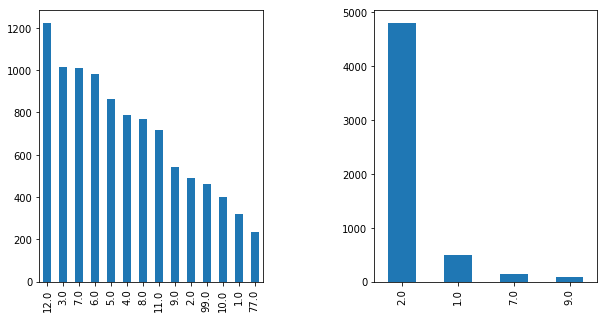

In [5]:
print("Number of respondents to Income questionnaire:", df_inc.shape[0])
print("Distribution of answers to \'monthly family income\' and \'Family savings\' questions:")

fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(wspace=0.5)
hist1 = df_inc['Monthly family income'].value_counts().plot(kind='bar', ax=axes[0])
hist2 = df_inc['Family has savings more than $5000'].value_counts().plot(kind='bar', ax=axes[1])
plt.show()

* The majority of individuals responded with a "12" for the question related to monthly family income, which means their income is above USD 8400 as explained [here](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/INQ_H.htm#IND235)
* To the question of whether the family has savings of more than USD 5000, the majority of individuals responded with a "2", which means "No"

<a name="summarize-questionnaire"></a>
## Summarize Income Questionnaire using Prototypes

Consider a social scientist who would like to quickly obtain a summary report of this dataset in terms of types of people that span this dataset. Is it possible to summarize this dataset by looking at answers given by a few representative/prototypical respondents? 

The Protodash algorithm can be used to obtain a few prototypical respondents (about 10 in this example) that span the diverse set of individuals answering the income questionnaire making it easy to summarize the dataset.

In [6]:
# convert pandas dataframe to numpy
data = df_inc.to_numpy()

#sort the rows by sequence numbers in 1st column 
idx = np.argsort(data[:, 0])  
data = data[idx, :]

# replace nan's (missing values) with 0's
original = data
original[np.isnan(original)] = 0

# delete 1st column (sequence numbers)
original = original[:, 1:]

print(original.shape)
original

(10175, 14)


array([[2., 2., 1., ..., 1., 9., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [2., 2., 1., ..., 3., 0., 0.],
       ...,
       [1., 2., 2., ..., 3., 0., 0.],
       [2., 2., 2., ..., 1., 2., 3.],
       [1., 2., 2., ..., 3., 0., 0.]])

In [7]:
# one hot encode all features as they are categorical
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(original)

In [8]:
print(onehot_encoded.shape)
onehot_encoded

(10175, 483)


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

### Why Protodash?

Prototypes represent the different segments in a dataset
* For example you might find that there are three categories of people: i) those that are high earners, ii) those that are middle class and iii) those that don't earn much or are unemployed and receive unemployment benefits
* Protodash will find these segments by pointing to specific individuals that lie in these categories
* From the objective function value of Protodash you are also able to say that three segments is the right number here as adding one more segment may not improve the objective value by much

The ['ProtodashExplainer'](v) provides exemplar-based explanations for summarizing datasets as well as explaining predictions.

* Input:  
    * Dataset to select prototypical explanations from: `onehot_encoded`
    * Dataset you want to explain: also `onehot_encoded`
    * Number of prototypes `m`
* Output:
* Indices of the selected prototypes `S`
* Importance weights associated with the selected prototypes `W`


In [9]:
explainer = ProtodashExplainer()

(W, S, _) = explainer.explain(onehot_encoded, onehot_encoded, m=10) 

# sort the order of prototypes in set S
idx = np.argsort(S)
S = S[idx]
W = W[idx]

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  3.6019e+01 -4.3677e+05  9e+01  1e+00  1e+00
 2:  2.8664e+00 -2.0364e+06  5e+02  1e+00  1e+00
 3:  1.6848e+01 -1.1632e+08  2e+04  1e+00  1e+00
 4:  3.5425e+01 -8.8167e+10  2e+07  1e+00  1e+00
 5:  1.9393e+05 -1.6204e+18  2e+18  5e-13  1e-03
 6:  1.9393e+05 -1.6204e+16  2e+16  5e-15  5e-04
 7:  1.9393e+05 -1.6204e+14  2e+14  6e-17  1e-05
 8:  1.9393e+05 -1.6204e+12  2e+12  3e-16  1e-07
 9:  1.9391e+05 -1.6204e+10  2e+10  2e-16  3e-09
10:  1.9189e+05 -1.6252e+08  2e+08  2e-16  3e-11
11:  9.7644e+04 -1.8416e+06  2e+06  2e-16  4e-13
12:  1.4907e+04 -3.3612e+04  5e+04  2e-16  5e-14
13:  2.1069e+03 -2.4523e+03  5e+03  6e-17  2e-14
14:  2.8232e+02 -3.7496e+02  7e+02  1e-16  5e-15
15:  3.1901e+01 -6.1651e+01  9e+01  9e-17  1e-15
16:  9.7377e-02 -1.2756e+01  1e+01  2e-16  7e-16
17: -3.2505e+00 -4.7374e+00  1e+00  9e-17  5e-16
18: -3.5543e+00 -3.7268e+00  2e-01  1e-16  8e-17
19: -3.5627e+00 -3.56

In [10]:
S

array([   8,  132,  690, 1475, 2449, 2912, 3899, 5077, 6895, 7475])

In [11]:
W

array([0.17411902, 0.06851631, 0.09200893, 0.06099008, 0.15060526,
       0.07124003, 0.11426933, 0.06656152, 0.0850852 , 0.09809455])

In [12]:
# Display the prototypes along with their computed weights
inc_prototypes = df_inc.iloc[S, :].copy()
# Compute normalized importance weights for prototypes
inc_prototypes["Weights of Prototypes"] = np.around(W/np.sum(W), 2) 
inc_prototypes.transpose()

,8,132,690,1475,2449,2912,3899,5077,6895,7475
Respondent sequence number,73565.00,73689.00,74247.00,75032.00,76006.00,76469.00,77456.00,78634.00,80452.00,81032.00
Income from wages/salaries,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00
Income from self employment,2.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00
Income from Social Security or RR,2.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,1.00
Income from other disability pension,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00
Income from retirement/survivor pension,2.00,2.00,2.00,2.00,2.00,1.00,2.00,1.00,2.00,2.00
Income from Supplemental Security Income,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00
Income from state/county cash assistance,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00
Income from interest/dividends or rental,2.00,1.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00,1.00
Income from other sources,2.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00


The 10 people shown above (i.e. 10 prototypes) are representative of the income questionnaire according to Protodash. 

* In the distribution plot for family finance related questions, there roughly were five times as many people not having savings in excess of USD 5000 compared with others. The prototypes also have a similar spread, which is reassuring
* For monthly family income, there is a more even spread over the more commonly occurring categories. This is a kind of spot check to see if our prototypes actually match the distribution of values in the dataset.
* Most people are employed (3rd question) and work for an organization earning through salary/wages (1st two questions)
* Most of them are also young (5th question) and fit to work (4th question)
* They don't seem to have much savings (last question)

<a name="find-questionnaire"></a>
## Find Questionnaires that are most representative of Income

How do the remaining 39 questionnaires represent or relate to income? The below will give an idea of which lifestyle factors are likely to affect income the most from prototypes for each of the questionnaires.

### Compute prototypes for all questionaires

This step uses Protodash explainer to compute 10 prototypes for each of the questionaires and saves these for further evaluation. (This takes a little while)

In [13]:
# Iterate through all questionnaire datasets and find 10 prototypes for each.

prototypes = {}

for i in range(len(nhanes_files)):
    
    f = nhanes_files[i]
    
    print("processing ", f)
    
    # read data to pandas dataframe
    df = nhanes.get_csv_file(f)
    
    # convert data to numpy
    data = df.to_numpy()

    #sort the rows by sequence numbers in 1st column 
    idx = np.argsort(data[:, 0])
    data = data[idx, :]

    # replace nan's with 0's.
    original = data
    original[np.isnan(original)] = 0

    # delete 1st column (contains sequence numbers)
    original = original[:, 1:]

    # one hot encode all features as they are categorical
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(original)

    explainer = ProtodashExplainer()

    # call Protodash explainer
    # S contains indices of the selected prototypes
    # W contains importance weights associated with the selected prototypes 

    (W, S, _) = explainer.explain(onehot_encoded, onehot_encoded, m=10) 

    prototypes[f]={}
    prototypes[f]['W']= W
    prototypes[f]['S']= S
    prototypes[f]['data'] = data
    prototypes[f]['original'] = original

processing  ACQ_H.csv
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.5310e+01 -2.0066e+05  4e+01  1e+00  1e+00
 2:  2.2661e-01 -2.9693e+06  6e+02  1e+00  1e+00
 3:  4.5958e+00 -4.9296e+08  1e+05  1e+00  1e+00
 4:  2.5900e+06 -1.1503e+16  1e+16  4e-13  4e-05
 5:  2.5900e+06 -1.1503e+14  1e+14  4e-15  9e-06
 6:  2.5900e+06 -1.1503e+12  1e+12  2e-16  1e-07
 7:  2.5892e+06 -1.1510e+10  1e+10  3e-16  7e-10
 8:  2.5107e+06 -1.2228e+08  1e+08  3e-16  2e-11
 9:  7.7656e+05 -2.8694e+06  4e+06  1e-16  6e-13
10:  1.1690e+05 -1.4468e+05  3e+05  2e-16  2e-13
11:  1.6636e+04 -1.8584e+04  4e+04  2e-16  7e-14
12:  2.3433e+03 -2.7242e+03  5e+03  2e-16  5e-15
13:  3.1920e+02 -4.0603e+02  7e+02  1e-16  3e-15
14:  3.8823e+01 -6.4788e+01  1e+02  3e-16  0e+00
15:  2.2958e+00 -1.2253e+01  1e+01  8e-17  9e-16
16: -1.6449e+00 -3.4574e+00  2e+00  2e-16  9e-16
17: -1.8754e+00 -2.1093e+00  2e-01  2e-16  1e-16
18: -1.8873e+00 -1.8948e+00  7e-03  3e-17  4e-17

### Evaluate the set of prototypical respondents from various questionaires using their income questionaire. 

How well do the prototypes of each questionaire represent the Income questionnaire based on the objective function that Protodash uses?

By ranking the different questionnaires with their objective function values in ascending order. The higher a questionaire appears in the list, the better its prototypes represent the income questionaire. The values on the right indicate our objective value where lower value is better.

In [14]:
#load income dataset INQ_H and its prototypes
X = prototypes['INQ_H.csv']['original']
Xdata = prototypes['INQ_H.csv']['data']

# Iterate through all questionnaires and evaluate how well their prototypes represent the income dataset. 
objs = []
for i in range(len(nhanes_files)):
        
    #load a dataset, its prototypes & weights

    f = nhanes_files[i]
    
    Ydata = prototypes[f]['data']
    S = prototypes[f]['S']
    W = prototypes[f]['W']
    
    
    # sort the order of prototypes in set S
    idx = np.argsort(S)
    S = S[idx]
    W = W[idx]
    
    # access corresponding prototypes in X. 
    XS = X[np.isin(Xdata[:, 0], Ydata[S, 0]), :]
    
    #print(Ydata[S, 0])
    #print(Xdata[np.isin(Xdata[:, 0], Ydata[S, 0]), 0])   
    
    temp = np.dot(XS, np.transpose(X))    
    u = np.sum(temp, axis=1)/temp.shape[1]
    
    K = np.dot(XS, XS.T)
    
    # evaluate prototypes on income based on our objective function with dot product as similarity measure
    obj = 0.5 * np.dot(np.dot(W.T, K), W) - np.dot(W.T, u)
    objs.append(obj)    
    

# sort the objectives (ascending order) 
index = np.argsort(np.array(objs))

# load the results in a dataframe to print
evalresult = []
for i in range(0,len(index)):    
    evalresult.append([ nhanesinfo[index[i]], objs[index[i]] ])
    
    
df_evalresult = pd.DataFrame.from_records(evalresult)
df_evalresult.columns = ['Questionaire', 'Prototypes representative of Income']
df_evalresult

,Questionaire,Prototypes representative of Income
0,Early Childhood,-96.119374
1,Physical Functioning,-95.584095
2,Acculturation,-95.355642
3,Physical Activity,-93.944968
4,Smoking - Secondhand Smoke Exposure,-93.192828
5,Cognitive Functioning,-93.050548
6,Diabetes,-91.381705
7,Taste & Smell,-90.633807
8,Disability,-89.223695
9,Smoking - Recent Tobacco Use,-88.301850


### Insight from Protodash

* Early childhood represents income the most. The early childhood questionnaire has information about the environment that the child was born and raised in
* This is consistent with a [long term study](https://www.theatlantic.com/business/archive/2016/07/social-mobility-america/491240/) that talks about significant decrease in social mobility in recent times, stressing the fact that your childhood impacts how monetarily successful you are likely to be
* Protodash was able to uncover this relationship with access to just these survey questionnaires

<a class="anchor" id="IRIS"></a>
# Understanding model predictions - IRIS

There are two ways to use [SHAP](https://github.com/slundberg/shap) explainers after installing aix360. In this notebook they are invoked similarly to other explainer algorithms in aix360 via the implemented wrapper classes. But since SHAP comes pre-installed in aix360, the explainers can simply be invoked directly.

<a class="anchor" id="explain-single-shap"></a>
## Explain a single prediction

An example with a K nearest neighbors ([knn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) classification of the IRIS dataset based on the [original SHAP tutorial](https://slundberg.github.io/shap/notebooks/Iris%20classification%20with%20scikit-learn.html).

Learn more about SHAP in [this chapter](https://christophm.github.io/interpretable-ml-book/shap.html#shap-summary-plot) in the Interpretable Machine Learning by Christoph Molnar.

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. Features with large absolute Shapley values are important. 

In [15]:
shap.datasets.iris()

(     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                  5.1               3.5                1.4               0.2
 1                  4.9               3.0                1.4               0.2
 2                  4.7               3.2                1.3               0.2
 3                  4.6               3.1                1.5               0.2
 4                  5.0               3.6                1.4               0.2
 5                  5.4               3.9                1.7               0.4
 6                  4.6               3.4                1.4               0.3
 7                  5.0               3.4                1.5               0.2
 8                  4.4               2.9                1.4               0.2
 9                  4.9               3.1                1.5               0.1
 10                 5.4               3.7                1.5               0.2
 11                 4.8               3.4           

In [16]:
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)

def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

shap.initjs()

n_neighbors = 5   # default=5
weights='uniform'  # 'uniform' or 'distance'
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
knn.fit(X_train, Y_train)

print_accuracy(knn.predict)

Accuracy = 96.66666666666667%


In [17]:
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
137,6.4,3.1,5.5,1.8
84,5.4,3.0,4.5,1.5
27,5.2,3.5,1.5,0.2
127,6.1,3.0,4.9,1.8
132,6.4,2.8,5.6,2.2


In [18]:
Y_train

array([2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0,
       1, 0, 2, 1, 0, 1, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2,
       0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1,
       0, 2, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 1,
       1, 1, 1, 0, 0, 0, 2, 1, 2, 0])

In [19]:
# probability estimates
knn.predict_proba(X_train)

array([[0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.2, 0.8],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.2, 0.8],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0.6, 0.4],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0.8, 0.2],
       [0. , 1. , 0. ],
       [0. , 0.2, 0.8],
       [0. , 0.4, 0.6],
       [0. , 0.8, 0.2],
       [0. , 0.4, 0.6],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.2, 0.8],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.8, 0.2],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. 

In [20]:
shapexplainer = KernelExplainer(knn.predict_proba, X_train)

W0825 17:16:44.241233 140165013120832 kernel.py:108] Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [21]:
help(shapexplainer)

Help on KernelExplainer in module aix360.algorithms.shap.shap_wrapper object:

class KernelExplainer(aix360.algorithms.lbbe.LocalBBExplainer)
 |  This class wraps the source class `KernelExplainer <https://shap.readthedocs.io/>`_
 |  available in the `SHAP <https://github.com/slundberg/shap>`_ library.
 |  Additional variables or functions from the source class can also be accessed via the 'explainer'
 |  object variable that is initialized in '__init__' function of this class.
 |  
 |  Method resolution order:
 |      KernelExplainer
 |      aix360.algorithms.lbbe.LocalBBExplainer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *argv, **kwargs)
 |      Initialize shap kernelexplainer object.
 |  
 |  explain_instance(self, *argv, **kwargs)
 |      Explain one ore more input instances.
 |  
 |  set_params(self, *argv, **kwargs)
 |      Optionally, set parameters for the explainer.
 |  
 |  --------------------------------------------------

In [22]:
# aix360 style for explaining input instances
shap_values = shapexplainer.explain_instance(X_test.iloc[0,:])

In [23]:
X_test.iloc[0,:]

sepal length (cm)    5.8
sepal width (cm)     2.8
petal length (cm)    5.1
petal width (cm)     2.4
Name: 114, dtype: float64

### The individual force plot

Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.

In [24]:
shapexplainer.explainer.expected_value[0]

0.3250000000000002

In [25]:
shap_values[0]

array([-0.00125   , -0.00875   , -0.29791667, -0.01708333])

In [26]:
shap.force_plot(shapexplainer.explainer.expected_value[0], shap_values[0], X_test.iloc[0,:])

In [27]:
X_test.iloc[23,:]

sepal length (cm)    4.4
sepal width (cm)     2.9
petal length (cm)    1.4
petal width (cm)     0.2
Name: 8, dtype: float64

In [28]:
shap_values = shapexplainer.explain_instance(X_test.iloc[23,:])
shap.force_plot(shapexplainer.explainer.expected_value[0], shap_values[0], X_test.iloc[23,:])

<a class="anchor" id="explain-all-shap"></a>
## Explain all predictions


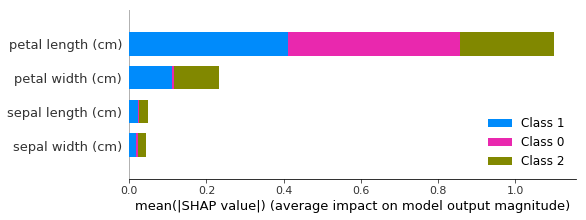

In [29]:
shap_values_all = shapexplainer.explain_instance(X_test)
shap.summary_plot(shap_values_all, X_test, plot_type="bar")

In [30]:
# aix360 style for explaining input instances
shap_values = shapexplainer.explain_instance(X_test)
shap.force_plot(shapexplainer.explainer.expected_value[0], shap_values[0], X_test)

<a class="anchor" id="retention"></a>
# Employee Retention

The **TED_CartesianExplainer** is an implementation of the algorithm in the AIES'19 paper by [Hind et al.]() It is most suited for use cases where matching explanations to the mental model of the explanation consumer is the highest priority; i.e., where the explanations are similar to what would be produced by a domain expert.

There are many approaches to implementing this functionality. Below the **TED_CartesianExplainer** is used, which simply takes the Cartesian product of the label and explanation and creates a new label (YE) and uses this to train a (multiclass) classifier. 

### [A deck of cards](https://en.wikipedia.org/wiki/Cartesian_product)

* An illustrative example is the standard 52-card deck
* The standard playing card ranks {A, K, Q, J, 10, 9, 8, 7, 6, 5, 4, 3, 2} form a 13-element set
* The card suits {♠, ♥, ♦, ♣} form a four-element set
* The Cartesian product of these sets returns a 52-element set consisting of 52 ordered pairs, which correspond to all 52 possible playing cards.

This simple cartesian product approach is quite general in that it can use any classifier (passed as a parameter), as long as it complies with the fit/predict paradigm.

## Synthetic dataset

A synthetically generated [dataset](https://github.com/IBM/AIX360/blob/master/aix360/data/ted_data/Retention.csv) is used with this [code](https://github.com/IBM/AIX360/blob/master/aix360/data/ted_data/GenerateData.py) that is part of aix360.

### Assigning labels

25 rules are created, for why a retention action is needed to reduce the chances of an employee choosing to leave our fictitious company. These rules are motivated by common scenarios, such as not getting a promotion in a while, not being paid competitively, receiving a disappointing evaluation, being a new employee in certain organizations with inherently high attrition, not having a salary that is consistent with positive evaluations, mid-career crisis, etc.   

Each of these 25 rules would result in the label "Yes"; i.e., the employee is a risk to leave the company. Because the rules capture the reason for the "Yes", we use the rule number as the explanation (E), which is required by the TED framework.

If none of the rules are satisfied, it means the employee is not a candidate for a retention action; i.e., a "No" label is assigned.  

### Dataset characteristics

10,000 fictious employees (X) are generated and the 26 (25 Yes + 1 No) rules are applied to produce Yes/No labels (Y), using these rules as explanations (E).  After applying these rules, the resulting dataset has the following characteristics:
- Yes (33.8%)
- No (66.2%)

First create a new TEDDataset object based on the "Retention.csv" file. The load_file method decomposes the dataset into its X, Y, and E components. (See [TEDDataset class](https://github.com/IBM/AIX360/blob/master/aix360/datasets/ted_dataset.py) for the expected format.):

In [31]:
# Decompose the dataset into X, Y, E     
X, Y, E = TEDDataset().load_file('Retention.csv')
print("X's shape:", X.shape)
print("Y's shape:", Y.shape)
print("E's shape:", E.shape)
print()

X's shape: (10000, 8)
Y's shape: (10000,)
E's shape: (10000,)



In [32]:
X

,0,1,2,3,4,5,6,7
0,3,1,-11,-2,-2,-2,296,0
1,1,2,-11,-3,-2,-2,22,22
2,4,2,-11,-2,-2,-2,5,5
3,3,3,-10,-2,-2,-3,227,2
4,1,1,-10,-2,-2,-2,187,20
5,2,2,-11,-2,-2,-2,5,5
6,3,2,-11,-2,-2,-2,52,4
7,2,3,-10,-2,-1,-2,30,11
8,1,2,-11,-2,-2,-1,41,6
9,1,3,-11,-2,-2,-2,216,5


Partition these instances into train and test sets:

In [33]:
# set up train/test split
X_train, X_test, Y_train, Y_test, E_train, E_test = train_test_split(X, Y, E, test_size=0.20, random_state=0)
print("X_train shape:", X_train.shape, ", X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape, ", Y_test shape:", Y_test.shape)
print("E_train shape:", E_train.shape, ", E_test shape:", E_test.shape)

X_train shape: (8000, 8) , X_test shape: (2000, 8)
Y_train shape: (8000,) , Y_test shape: (2000,)
E_train shape: (8000,) , E_test shape: (2000,)


## Train a classifier

In [34]:
# Create classifier and pass to TED_CartesianExplainer
estimator = svm.SVC(kernel='linear')
# estimator = DecisionTreeClassifier()
# estimator = RandomForestClassifier()
# estimator = AdaBoostClassifier()

ted = TED_CartesianExplainer(estimator)

In [35]:
print("Training the classifier")

ted.fit(X_train, Y_train, E_train)   # train classifier

Training the classifier


<a class="anchor" id="ted1"></a>
## Explain a single prediction

The trained TED classifier is now ready for predictions with explanations.   We construct some raw feature vectors, created from the original dataset, and ask for a label (Y) prediction and its explanation (E).

In [36]:
# Create an instance level example 
X1 = [[1, 2, -11, -3, -2, -2,  22, 22]]

# correct answers:  Y:-10; E:13
Y1, E1 = ted.predict_explain(X1)
print("Predicting for feature vector:")
print(" ", X1[0])
print("\t\t      Predicted \tCorrect")
print("Label(Y)\t\t " + np.array2string(Y1[0]) + "\t\t   -10")
print("Explanation (E) \t " + np.array2string(E1[0]) + "\t\t   13")
print()

Predicting for feature vector:
  [1, 2, -11, -3, -2, -2, 22, 22]
		      Predicted 	Correct
Label(Y)		 -10		   -10
Explanation (E) 	 13		   13



In [37]:
X2 = [[3, 1, -11, -2, -2, -2, 296, 0]]

## correct answers: Y:-11, E:25
Y2, E2 = ted.predict_explain(X2)
print("Predicting for feature vector:")
print(" ", X2[0])

print("\t\t      Predicted \tCorrect")
print("Label(Y)\t\t " + np.array2string(Y2[0]) + "\t\t   -11")
print("Explanation (E) \t " + np.array2string(E2[0]) + "\t\t   25")

Predicting for feature vector:
  [3, 1, -11, -2, -2, -2, 296, 0]
		      Predicted 	Correct
Label(Y)		 -11		   -11
Explanation (E) 	 25		   25


In [38]:
Y2

array([-11])

In [39]:
E2

array([25])

### Create a more relevant human interface

TED_CaresianExplainer can produce the correct explanation for a feature vector, but simply producing "3" as an explanation is not sufficient in most uses. This section shows one way to implement the mapping of real explanations to the explanation IDs that TED requires. This is inspired by the [FICO reason codes](https://www.fico.com/en/latest-thinking/product-sheet/us-fico-score-reason-codes), which are explanations for a FICO credit score.  

In this case the explanations are text, but the same idea can be used to map explanation IDs to other formats, such as a file name containing an audio or video explanation.

In [40]:
Label_Strings =["IS", "Approved for"]
def labelToString(label) :
    if label == -10 :
        return "IS"
    else :
        return "IS NOT"

Explanation_Strings = [
    "Seeking Higher Salary in Org 1",
    "Promotion Lag, Org 1, Position 1",
    "Promotion Lag, Org 1, Position 2",
    "Promotion Lag, Org 1, Position 3",
    "Promotion Lag, Org 2, Position 1",
    "Promotion Lag, Org 2, Position 2",
    "Promotion Lag, Org 2, Position 3",
    "Promotion Lag, Org 3, Position 1",
    "Promotion Lag, Org 3, Position 2",
    "Promotion Lag, Org 3, Position 3",
    "New employee, Org 1, Position 1",
    "New employee, Org 1, Position 2",
    "New employee, Org 1, Position 3",
    "New employee, Org 2, Position 1",
    "New employee, Org 2, Position 2",
    "Disappointing evaluation, Org 1",
    "Disappointing evaluation, Org 2",
    "Compensation does not match evaluations, Med rating",
    "Compensation does not match evaluations, High rating",
    "Compensation does not match evaluations, Org 1, Med rating",
    "Compensation does not match evaluations, Org 2, Med rating",
    "Compensation does not match evaluations, Org 1, High rating",
    "Compensation does not match evaluations, Org 2, High rating",
    "Mid-career crisis, Org 1",
    "Mid-career crisis, Org 2",
    "Did not match any retention risk rules"]


print("Employee #1 " + labelToString(Y1[0]) + " a retention risk with explanation: " + Explanation_Strings[E1[0]])
print()
print("Employee #2 " + labelToString(Y2[0]) + " a retention risk with explanation: " + Explanation_Strings[E2[0]])

Employee #1 IS a retention risk with explanation: New employee, Org 2, Position 1

Employee #2 IS NOT a retention risk with explanation: Did not match any retention risk rules


<a class="anchor" id="ted2"></a>
## Overall model accuracy

How well does TED_Cartesian do in predicting all test labels (Y) and explanations (E)?

The "score" method of TED_Cartesian calculates this. The accuracy of predicting the combined YE labels could be of interest to researchers who want to better understand the inner workings of TED_Cartesian.


In [41]:
YE_accuracy, Y_accuracy, E_accuracy = ted.score(X_test, Y_test, E_test)    # evaluate the classifier
print("Evaluating accuracy of TED-enhanced classifier on test data")
print(' Accuracy of predicting Y labels: %.2f%%' % (100*Y_accuracy))
print(' Accuracy of predicting explanations: %.2f%%' % (100*E_accuracy))
print(' Accuracy of predicting Y + explanations: %.2f%%' % (100*YE_accuracy))

Evaluating accuracy of TED-enhanced classifier on test data
 Accuracy of predicting Y labels: 86.15%
 Accuracy of predicting explanations: 85.10%
 Accuracy of predicting Y + explanations: 85.10%


* It is easy to use the TED_CartesianExplainer if you have a training dataset that contains explanations. The framework is general in that it can use any classification technique that follows the fit/predict paradigm, so that if you already have a favorite algorithm, you can use it with the TED framework.
* The main advantage of this algorithm is that the quality of the explanations produced are exactly the same quality as those that the algorithm is trained on.  Thus, if you teach (train) the system well with good training data and good explanations, you will get good explanations out in a language you should understand.
* The downside of this approach is that someone needs to create explanations. This should be straightforward when a domain expert is creating the initial training data: if they decide a loan should be rejected, they should know why, and if they do not, it may not be a good decision.
* However, this may be more of a challenge when a training dataset already exists without explanations and now someone needs to create the explanations.  The original person who did the labeling of decisions may no longer be available, so the explanations for the decisions may not be known.  In this case, we argue, the system is in a dangerous state.  Training data exists that no one understands why it is labeled in a certain way.   Asking the model to explain one of its predictions when no person can explain an instance in the training data does not seem consistent.
* Dealing with this situation is one of the open research problems that comes from the TED approach.

# Next time

* Case study with the **Home Equity Line of Credit (HELOC) Dataset**: anonymized information about HELOC applications made by real homeowners
* The customers in this dataset have requested a credit line in the range of USD 5,000 - 150,000
* Use the information about the applicant in their credit report to predict whether they will make timely payments over a two year period
* The machine learning prediction can then be used to decide whether the homeowner qualifies for a line of credit and, if so, how much credit should be extended
